In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_directory(directory, img_height, img_width):
    images = []
    for filename in os.listdir(directory):
        img = load_img(os.path.join(directory, filename), color_mode='grayscale', target_size=(img_height, img_width))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

img_height, img_width = 64, 2048
comp_font_dir = '/Selected_Comp'
lg_font_dir = '/Selected_LG'

comp_images = load_images_from_directory(comp_font_dir, img_height, img_width)
lg_images = load_images_from_directory(lg_font_dir, img_height, img_width)

# Normalize images to the range [0, 1]
comp_images = comp_images.astype('float32') / 255.0
lg_images = lg_images.astype('float32') / 255.0

# Manually split the dataset into training and validation sets
val_split_index = int(0.9 * len(comp_images))
comp_train, comp_val = comp_images[:val_split_index], comp_images[val_split_index:]
lg_train, lg_val = lg_images[:val_split_index], lg_images[val_split_index:]

print("Training set:", comp_train.shape, lg_train.shape)
print("Validation set:", comp_val.shape, lg_val.shape)


2024-07-14 09:22:36.683427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 09:22:36.701567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 09:22:36.723511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 09:22:36.729813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 09:22:36.746565: I tensorflow/core/platform/cpu_feature_guar

Training set: (900, 64, 2048, 1) (900, 64, 2048, 1)
Validation set: (100, 64, 2048, 1) (100, 64, 2048, 1)


In [2]:
from tensorflow.keras import layers, Model

def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    b = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    b = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(b)
    
    # Decoder
    u4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b)
    u4 = layers.concatenate([u4, c4])
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    u3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u3 = layers.concatenate([u3, c3])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    
    u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c8)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

input_shape = (img_height, img_width, 1)
model = unet_model(input_shape)
model.summary()


2024-07-14 09:22:42.869797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43526 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0001:6f:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 2048,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 2048,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 2048,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 1024,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 1024,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 1024,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 512,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 512,   │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 512,   │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 256,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 256,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 256,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 128,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 128,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 4, 128,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 256,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 256,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
vgg.trainable = False

def perceptual_loss(y_true, y_pred):
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)
    y_true_features = vgg(y_true_rgb)
    y_pred_features = vgg(y_pred_rgb)
    return tf.reduce_mean(tf.abs(y_true_features - y_pred_features))

class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, l1_weight=1.0, perceptual_weight=100.0):  # Reduced L1 weight
        super(CustomLoss, self).__init__()
        self.l1_weight = l1_weight
        self.perceptual_weight = perceptual_weight

    def call(self, y_true, y_pred):
        return self.l1_weight * l1_loss(y_true, y_pred) + self.perceptual_weight * perceptual_loss(y_true, y_pred)


In [5]:
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
model.compile(optimizer=optimizer, loss=CustomLoss(l1_weight=1.0, perceptual_weight=100.0))

In [ ]:
# Train the model with the callback
history = model.fit(comp_train, lg_train, epochs=50, batch_size=1, validation_data=(comp_val, lg_val))


Epoch 1/50


I0000 00:00:1720948981.534356   79423 service.cc:146] XLA service 0x7f934800b000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720948981.534462   79423 service.cc:154]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2024-07-14 09:23:01.730705: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-14 09:23:02.833149: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-07-14 09:23:04.663351: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 129.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-14 09:23:06.035495: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (G

  5/900 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 10.4342 

I0000 00:00:1720948988.461793   79423 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.5526

2024-07-14 09:23:34.098252: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 258.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-14 09:23:34.140817: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 516.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


900/900 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 8.5513 - val_loss: 7.0763
Epoch 2/50
117/900 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 7.0251

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


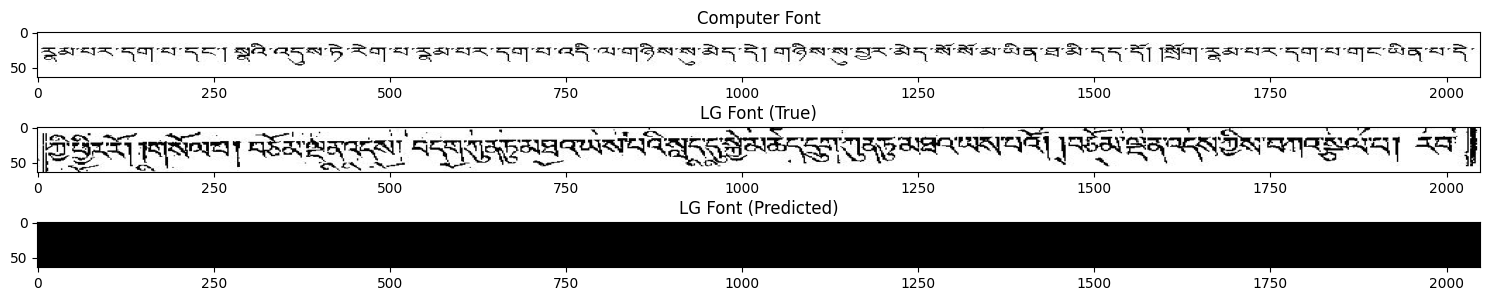

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to plot images on different lines
def plot_images(comp_img, lg_img, pred_img):
    fig, axes = plt.subplots(3, 1, figsize=(15, 3))
    
    axes[0].imshow(comp_img, cmap='gray')
    axes[0].set_title('Computer Font')
    
    axes[1].imshow(lg_img, cmap='gray')
    axes[1].set_title('LG Font (True)')
    
    axes[2].imshow(pred_img, cmap='gray')
    axes[2].set_title('LG Font (Predicted)')
    
    plt.tight_layout()
    plt.show()

# Generate prediction and plot the result for a single example from the validation set
comp_img = comp_val[0]
lg_img = lg_val[0]
pred_img = model.predict(comp_img[np.newaxis, ...])[0]

plot_images(comp_img.squeeze(), lg_img.squeeze(), pred_img.squeeze())
